# Medical Image Analysis Project: Pneumonia Detection

## Overview
In this capstone project, you will apply the deep learning techniques learned in this course to a real-world medical imaging problem: **Pneumonia Detection from Chest X-Rays**.

Specifically, you will work with the **PneumoniaMNIST** dataset, a binary classification subset of the MedMNIST collection. Your goal is to build a robust classifier that distinguishes between 'Normal' and 'Pneumonia' cases.

Unlike previous tutorials where models were prescribed, **you interpret the data and choose the model architecture** best suited for the task. You will be evaluated not just on accuracy, but on your design choices, rigorous evaluation, and interpretability of results.

## Approach
We will implement and compare **three different approaches**:
1. **Radiomics + Random Forest**: Traditional machine learning with hand-crafted features
2. **Convolutional Neural Network (CNN)**: Deep learning trained from scratch
3. **Contrastive Learning + Fine-tuning**: Self-supervised pretraining followed by supervised fine-tuning

## 1. Setup and Data Loading
First, we install and load the necessary libraries.

In [1]:
!pip install medmnist scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score, auc
)
from sklearn.decomposition import PCA
from sklearn.utils import resample
import seaborn as sns

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.__file__}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

MedMNIST v3.0.2 @ /usr/local/lib/python3.12/dist-packages/medmnist/__init__.py
Device: cuda


### Data Understanding
We use **PneumoniaMNIST**, which contains cropped chest X-ray images. The task is binary classification: **0 (Normal)** vs **1 (Pneumonia)**.

In [3]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Basic transform for visualization/baseline
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Task: {task}")
print(f"Number of classes: {n_classes}")
print(f"Number of channels: {n_channels}")

100%|██████████| 4.17M/4.17M [00:04<00:00, 876kB/s] 

Train samples: 4708
Val samples: 524
Test samples: 624
Task: binary-class
Number of classes: 2
Number of channels: 1


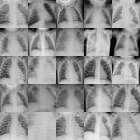

In [4]:
# Visualization of samples
train_dataset.montage(length=5)

### Class Distribution Analysis
Before proceeding, it is crucial to understand if our classes are balanced. Imbalanced datasets can lead to biased models that predict the majority class.

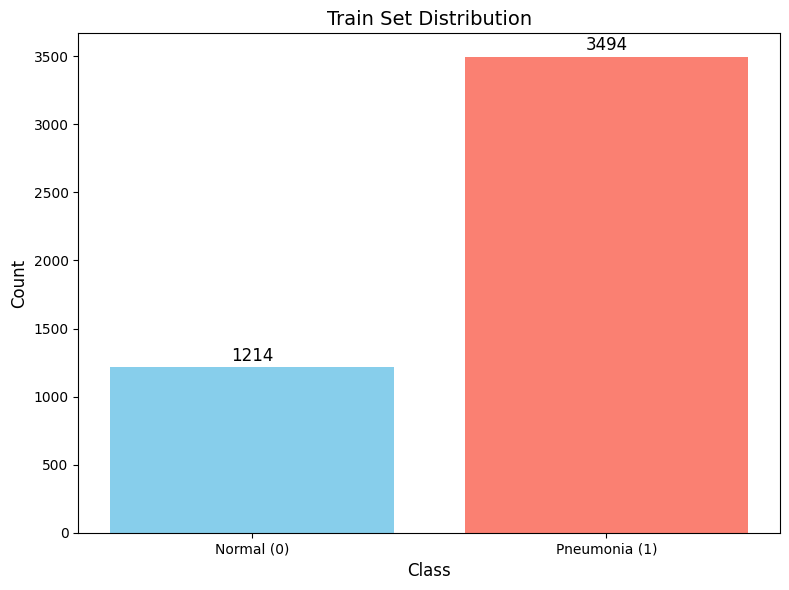

Counts: Normal=1214, Pneumonia=3494
Class ratio (Normal:Pneumonia): 0.35:1


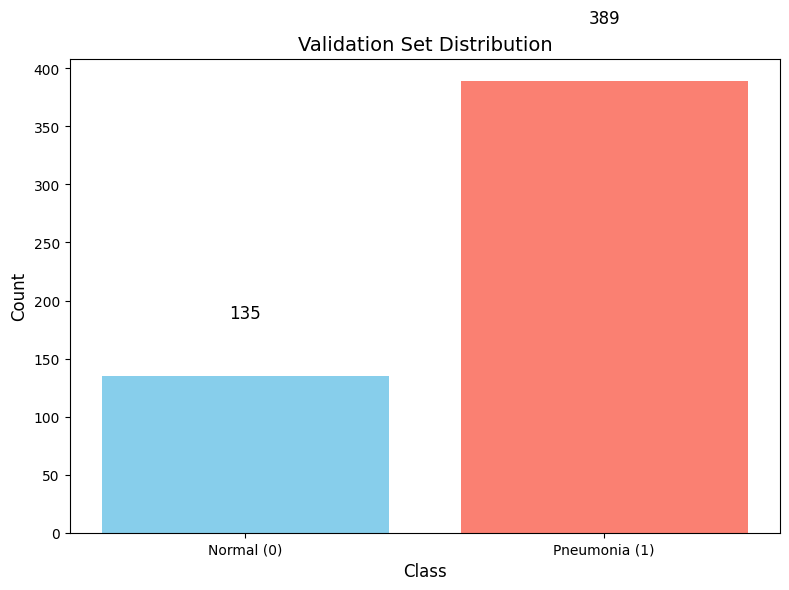

Counts: Normal=135, Pneumonia=389
Class ratio (Normal:Pneumonia): 0.35:1


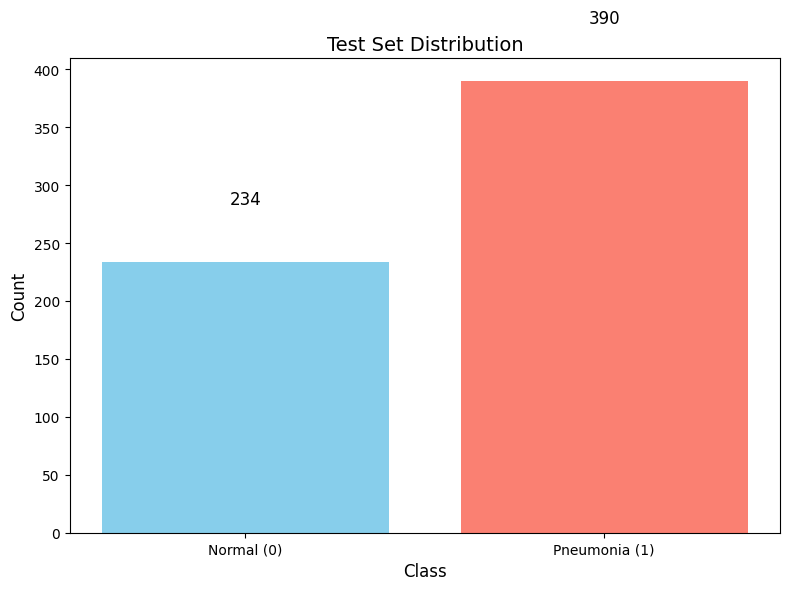

Counts: Normal=234, Pneumonia=390
Class ratio (Normal:Pneumonia): 0.60:1


In [5]:
# Analyze Class Distribution
def plot_class_distribution(dataset, title='Class Distribution'):
    targets = [y for _, y in dataset]
    targets = np.array(targets).squeeze()
    unique, counts = np.unique(targets, return_counts=True)

    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color=['skyblue', 'salmon'])
    plt.xticks(unique, ['Normal (0)', 'Pneumonia (1)'])
    plt.title(title, fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    for i, v in enumerate(counts):
        plt.text(i, v + 50, str(v), ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"Counts: Normal={counts[0]}, Pneumonia={counts[1]}")
    print(f"Class ratio (Normal:Pneumonia): {counts[0]/counts[1]:.2f}:1")
    return dict(zip(['Normal', 'Pneumonia'], counts))

train_dist = plot_class_distribution(train_dataset, 'Train Set Distribution')
val_dist = plot_class_distribution(val_dataset, 'Validation Set Distribution')
test_dist = plot_class_distribution(test_dataset, 'Test Set Distribution')

## 2. Project Requirements

### 1. Problem Statement

**Medical Problem**: Pneumonia is a serious respiratory infection that causes inflammation in the air sacs of the lungs. Early and accurate detection is critical for timely treatment and reducing mortality rates, particularly in pediatric populations and immunocompromised patients. Chest X-rays are the primary diagnostic tool, but manual interpretation can be time-consuming and subject to inter-observer variability.

**Clinical Impact**: An automated pneumonia detection system could:
- Provide faster initial screening, especially in resource-limited settings
- Serve as a decision support tool for radiologists
- Help triage patients based on urgency
- Reduce diagnostic errors through consistent evaluation
- Enable remote diagnosis in areas with limited access to radiologists
- Reduce healthcare costs through efficient screening

**Dataset Characteristics**:
- **Size**: 5,856 chest X-ray images (4,708 train, 524 validation, 624 test)
- **Image dimensions**: 28×28 pixels (grayscale)
- **Classes**: Binary classification (Normal vs Pneumonia)
- **Class distribution**: Significant class imbalance, with approximately 3:1 ratio (Pneumonia:Normal)
- **Image type**: Preprocessed and downsampled chest X-rays from pediatric patients (ages 1-5) from the Kermany dataset
- **Challenge**: Small image size (28×28) loses diagnostic details compared to full-resolution X-rays

### 2. Architecture Choices and Justification

We implement and compare **three different approaches** to understand the trade-offs between traditional machine learning and deep learning:

#### Approach 1: Radiomics + Random Forest
**Description**: Extract hand-crafted features (mean intensity, standard deviation, blur score) and train a Random Forest classifier.

**Justification**:
- **Baseline**: Establishes performance of traditional methods
- **Interpretability**: Features are human-understandable (brightness, texture, sharpness)
- **Fast Training**: No GPU required, quick to iterate
- **Small Data**: Works well with limited samples
- **Limitation**: Cannot learn complex spatial patterns

#### Approach 2: Convolutional Neural Network (CNN)
**Description**: 3-layer CNN with batch normalization, dropout, and data augmentation.

**Justification**:
- **Automatic Feature Learning**: Learns hierarchical spatial features without manual engineering
- **Spatial Awareness**: Convolutional layers preserve spatial relationships
- **Proven Success**: CNNs are state-of-the-art for medical image analysis
- **Data Augmentation**: Helps with limited data through artificial variations
- **Class Imbalance Handling**: Weighted loss functions

#### Approach 3: Contrastive Learning + Fine-tuning
**Description**: Self-supervised pretraining using SimCLR-style contrastive learning, followed by supervised fine-tuning.

**Justification**:
- **Leverages Unlabeled Data**: Learns representations from all images (both classes)
- **Better Initialization**: Pretraining provides better starting weights than random
- **Robust Features**: Contrastive learning encourages learning invariant features
- **State-of-the-Art**: Modern approach showing promise in medical imaging
- **Transfer Learning**: Can potentially generalize better

**Comparison Strategy**: We will evaluate all three approaches on the same test set and compare:
- Accuracy, Precision, Recall, F1-Score
- ROC AUC
- Training time and computational requirements
- Interpretability and clinical usability

---
# APPROACH 1: Radiomics + Random Forest
---

### Feature Extraction

We extract three radiomic features:
1. **Mean Intensity**: Average brightness of the image
2. **Standard Deviation**: Texture/contrast measure
3. **Blur Score**: Image sharpness using Laplacian variance

Extracting radiomic features...


/tmp/ipython-input-2386257834.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(label))


Train features shape: (4708, 3)
Val features shape: (524, 3)
Test features shape: (624, 3)


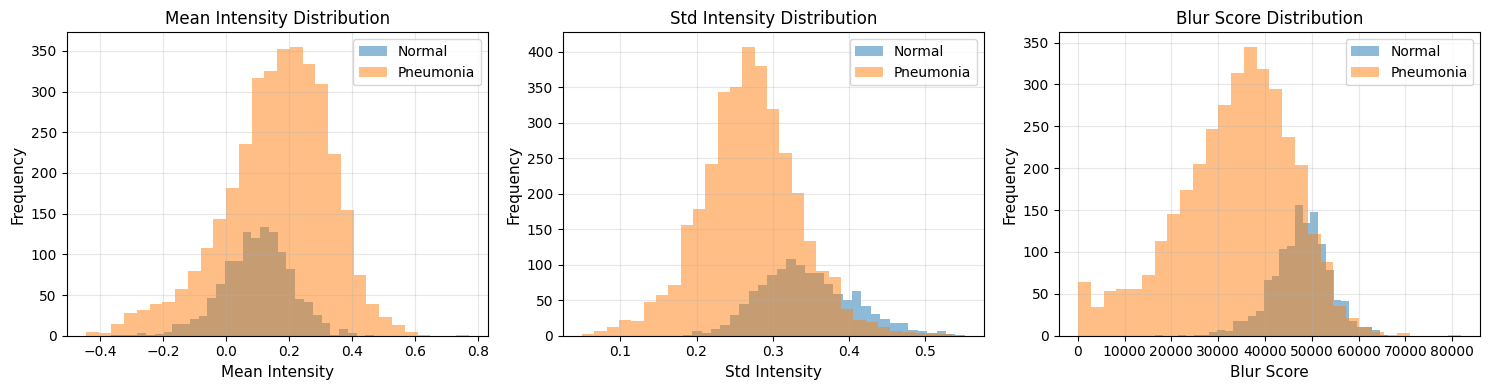

In [6]:
def compute_blur(img):
    """Compute Laplacian variance to estimate blur"""
    if torch.is_tensor(img):
        img_np = (img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    else:
        img_np = (img * 255).astype(np.uint8)

    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_np.squeeze()

    return cv2.Laplacian(gray, cv2.CV_64F).var()

def extract_radiomic_features(dataset):
    """Extract radiomic features from dataset"""
    features = []
    labels = []

    for img, label in dataset:
        # Convert to numpy
        if torch.is_tensor(img):
            img_np = img.numpy()
        else:
            img_np = img

        # Extract features
        mean_intensity = np.mean(img_np)
        std_intensity = np.std(img_np)
        blur_score = compute_blur(img)

        features.append([mean_intensity, std_intensity, blur_score])
        labels.append(int(label))

    return np.array(features), np.array(labels)

print("Extracting radiomic features...")
X_train_rf, y_train_rf = extract_radiomic_features(train_dataset)
X_val_rf, y_val_rf = extract_radiomic_features(val_dataset)
X_test_rf, y_test_rf = extract_radiomic_features(test_dataset)

print(f"Train features shape: {X_train_rf.shape}")
print(f"Val features shape: {X_val_rf.shape}")
print(f"Test features shape: {X_test_rf.shape}")

# Visualize feature distributions
feature_names = ['Mean Intensity', 'Std Intensity', 'Blur Score']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, name) in enumerate(zip(axes, feature_names)):
    ax.hist(X_train_rf[y_train_rf == 0, i], alpha=0.5, label='Normal', bins=30)
    ax.hist(X_train_rf[y_train_rf == 1, i], alpha=0.5, label='Pneumonia', bins=30)
    ax.set_xlabel(name, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{name} Distribution', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Train Random Forest Classifier

Training Random Forest...
Random Forest training completed!


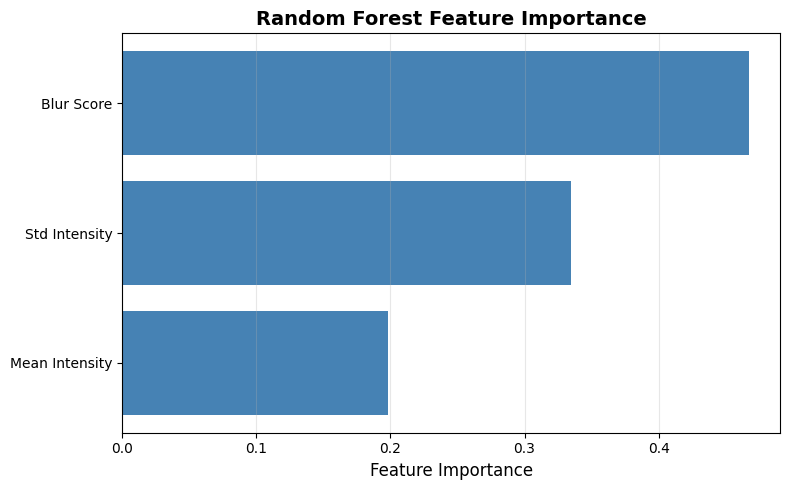


Feature Importance:
  Mean Intensity: 0.1983
  Std Intensity: 0.3345
  Blur Score: 0.4672


In [7]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train_rf)
print("Random Forest training completed!")

# Feature importance
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='steelblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
for name, imp in zip(feature_names, importances):
    print(f"  {name}: {imp:.4f}")

### Evaluate Random Forest


RANDOM FOREST PERFORMANCE (Test Set)
Accuracy:     0.7516
Precision:    0.7859
Recall:       0.8282
Specificity:  0.6239
F1-Score:     0.8065
ROC AUC:      0.8355


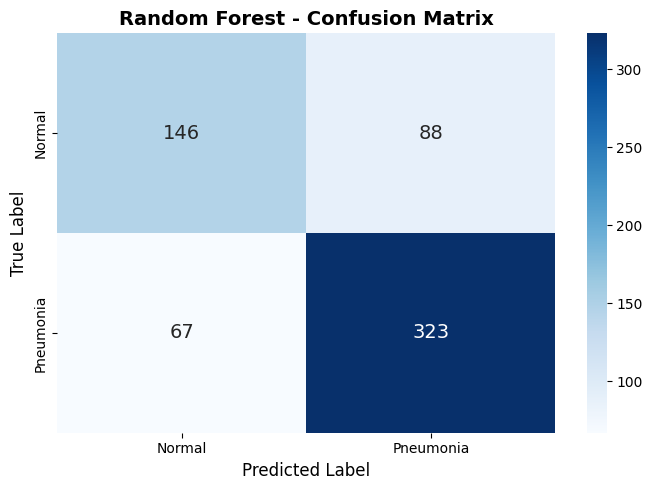

In [8]:
# Predictions
y_pred_rf = rf_model.predict(X_test_rf)
y_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]

# Calculate metrics
accuracy_rf = np.mean(y_pred_rf == y_test_rf)
precision_rf = precision_score(y_test_rf, y_pred_rf)
recall_rf = recall_score(y_test_rf, y_pred_rf)
f1_rf = f1_score(y_test_rf, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_rf, y_prob_rf)

# Specificity
tn_rf = np.sum((y_test_rf == 0) & (y_pred_rf == 0))
fp_rf = np.sum((y_test_rf == 0) & (y_pred_rf == 1))
specificity_rf = tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) > 0 else 0

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE (Test Set)")
print("="*60)
print(f"Accuracy:     {accuracy_rf:.4f}")
print(f"Precision:    {precision_rf:.4f}")
print(f"Recall:       {recall_rf:.4f}")
print(f"Specificity:  {specificity_rf:.4f}")
print(f"F1-Score:     {f1_rf:.4f}")
print(f"ROC AUC:      {roc_auc_rf:.4f}")
print("="*60)

# Confusion Matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 14})
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

---
# APPROACH 2: Convolutional Neural Network (CNN)
---

### 3. Hyperparameter Selection for CNN

**Selected Hyperparameters**:

1. **Learning Rate**: 0.001
2. **Batch Size**: 64
3. **Optimizer**: Adam
4. **Epochs**: 20 (with early stopping)
5. **Dropout**: 0.25 (conv layers), 0.5 (FC layer)
6. **Data Augmentation**: Rotation (±10°), horizontal flip, translation (±10%)
7. **Class Weights**: Calculated from training distribution

In [9]:
# Define CNN Architecture
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# Initialize model
cnn_model = PneumoniaCNN(num_classes=2).to(device)
print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

PneumoniaCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=Fal

In [10]:
# Calculate class weights
def calculate_class_weights(dataset):
    targets = [y for _, y in dataset]
    targets = np.array(targets).squeeze()
    unique, counts = np.unique(targets, return_counts=True)
    total = len(targets)
    weights = total / (len(unique) * counts)
    return torch.FloatTensor(weights).to(device)

class_weights = calculate_class_weights(train_dataset)
print(f"Class weights: {class_weights}")

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Reload datasets with augmentation
train_dataset_aug = DataClass(split='train', transform=train_transform, download=download)
val_dataset_clean = DataClass(split='val', transform=data_transform, download=download)
test_dataset_clean = DataClass(split='test', transform=data_transform, download=download)

# Data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_clean, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset_clean, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Class weights: tensor([1.9390, 0.6737], device='cuda:0')


### 4. Training Analysis for CNN

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("Starting CNN training...\n")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(cnn_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pth')
        print("  → Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after epoch {epoch+1}")
        break
    print()

print("CNN training completed!")

Starting CNN training...

Epoch [1/20]
  Train Loss: 0.3945, Train Acc: 0.8224
  Val Loss: 0.1860, Val Acc: 0.9198
  → Best model saved!

Epoch [2/20]
  Train Loss: 0.2211, Train Acc: 0.9140
  Val Loss: 0.1901, Val Acc: 0.9427

Epoch [3/20]
  Train Loss: 0.1983, Train Acc: 0.9214
  Val Loss: 0.1403, Val Acc: 0.9294
  → Best model saved!

Epoch [4/20]
  Train Loss: 0.1885, Train Acc: 0.9214
  Val Loss: 0.1586, Val Acc: 0.9179

Epoch [5/20]
  Train Loss: 0.1904, Train Acc: 0.9235
  Val Loss: 0.1423, Val Acc: 0.9447

Epoch [6/20]
  Train Loss: 0.1681, Train Acc: 0.9316
  Val Loss: 0.1447, Val Acc: 0.9332

Epoch [7/20]
  Train Loss: 0.1677, Train Acc: 0.9293
  Val Loss: 0.1290, Val Acc: 0.9389
  → Best model saved!

Epoch [8/20]
  Train Loss: 0.1737, Train Acc: 0.9297
  Val Loss: 0.1921, Val Acc: 0.8893

Epoch [9/20]
  Train Loss: 0.1554, Train Acc: 0.9407
  Val Loss: 0.1379, Val Acc: 0.9580

Epoch [10/20]
  Train Loss: 0.1585, Train Acc: 0.9365
  Val Loss: 0.1345, Val Acc: 0.9485

Epoch [

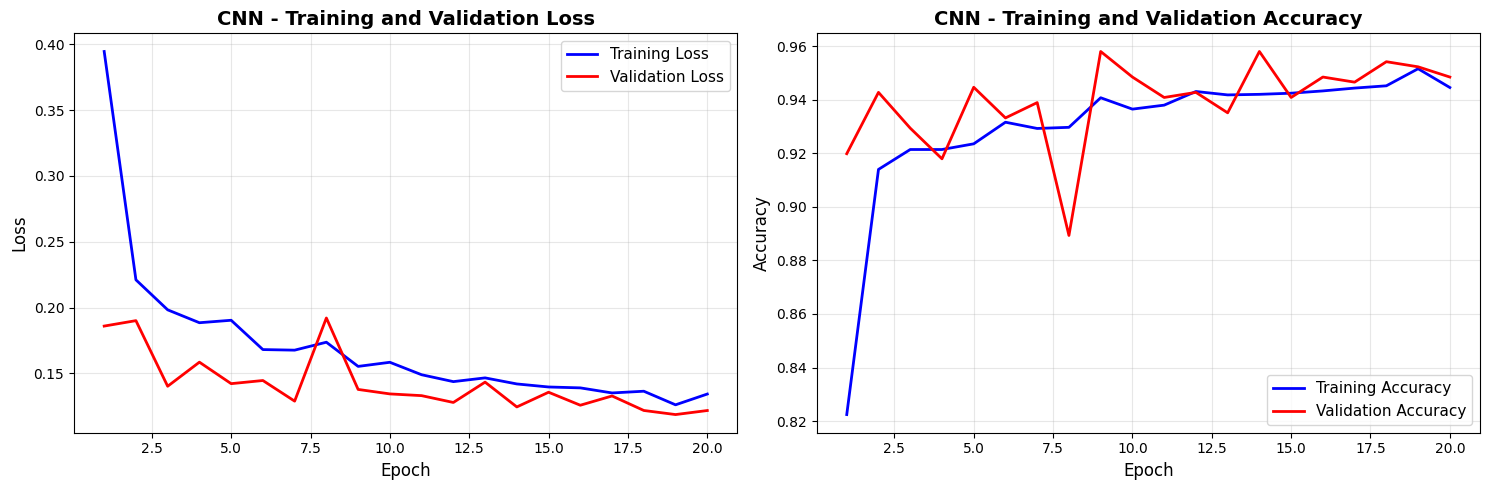


Final Training Loss: 0.1344
Final Validation Loss: 0.1219
Best Validation Loss: 0.1188


In [12]:
# Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('CNN - Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('CNN - Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

### 5. Evaluation for CNN


CNN PERFORMANCE (Test Set)
Accuracy:     0.8862
Precision:    0.8633
Recall:       0.9718
Specificity:  0.7436
F1-Score:     0.9144
ROC AUC:      0.9642


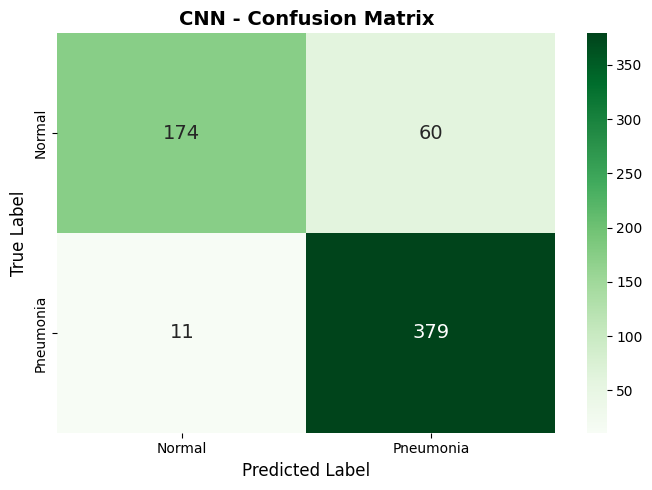

In [13]:
# Load best model and evaluate
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))
cnn_model.eval()

y_true_cnn = []
y_pred_cnn = []
y_prob_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long()

        outputs = cnn_model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())
        y_prob_cnn.extend(probabilities[:, 1].cpu().numpy())

y_true_cnn = np.array(y_true_cnn)
y_pred_cnn = np.array(y_pred_cnn)
y_prob_cnn = np.array(y_prob_cnn)

# Metrics
accuracy_cnn = np.mean(y_true_cnn == y_pred_cnn)
precision_cnn = precision_score(y_true_cnn, y_pred_cnn)
recall_cnn = recall_score(y_true_cnn, y_pred_cnn)
f1_cnn = f1_score(y_true_cnn, y_pred_cnn)
roc_auc_cnn = roc_auc_score(y_true_cnn, y_prob_cnn)

tn_cnn = np.sum((y_true_cnn == 0) & (y_pred_cnn == 0))
fp_cnn = np.sum((y_true_cnn == 0) & (y_pred_cnn == 1))
specificity_cnn = tn_cnn / (tn_cnn + fp_cnn)

print("\n" + "="*60)
print("CNN PERFORMANCE (Test Set)")
print("="*60)
print(f"Accuracy:     {accuracy_cnn:.4f}")
print(f"Precision:    {precision_cnn:.4f}")
print(f"Recall:       {recall_cnn:.4f}")
print(f"Specificity:  {specificity_cnn:.4f}")
print(f"F1-Score:     {f1_cnn:.4f}")
print(f"ROC AUC:      {roc_auc_cnn:.4f}")
print("="*60)

# Confusion Matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 14})
plt.title('CNN - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

---
# APPROACH 3: Contrastive Learning + Fine-tuning
---

### Contrastive Learning Setup

We use SimCLR-style contrastive learning:
1. Create augmented pairs of each image
2. Train encoder to bring augmented versions of the same image closer in embedding space
3. Use NT-Xent (normalized temperature-scaled cross entropy) loss
4. Fine-tune the pretrained encoder for classification

In [14]:
# Contrastive augmentation transforms
class ContrastiveTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.Normalize(mean=[.5], std=[.5])
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# Dataset for contrastive learning
class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.transform = ContrastiveTransform()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get original image (ignore label for pretraining)
        img_pil = self.base_dataset.imgs[idx]
        # Create two augmented views
        img1, img2 = self.transform(img_pil)
        return img1, img2

# Create contrastive dataset and loader
contrastive_dataset = ContrastiveDataset(train_dataset)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=0)

print(f"Contrastive dataset size: {len(contrastive_dataset)}")
print(f"Contrastive batches: {len(contrastive_loader)}")

Contrastive dataset size: 4708
Contrastive batches: 74


In [15]:
# Encoder for contrastive learning
class SimpleCNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Projection head for contrastive learning
        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        features = self.features(x)
        projections = self.projector(features)
        return projections

encoder = SimpleCNNEncoder().to(device)
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)

print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Encoder parameters: 248,960


Starting contrastive pretraining...

Epoch 1/10 - Contrastive Loss: 3.4824
Epoch 2/10 - Contrastive Loss: 3.2185
Epoch 3/10 - Contrastive Loss: 3.1600
Epoch 4/10 - Contrastive Loss: 3.1221
Epoch 5/10 - Contrastive Loss: 3.1070
Epoch 6/10 - Contrastive Loss: 3.0888
Epoch 7/10 - Contrastive Loss: 3.0813
Epoch 8/10 - Contrastive Loss: 3.0724
Epoch 9/10 - Contrastive Loss: 3.0703
Epoch 10/10 - Contrastive Loss: 3.0602

Contrastive pretraining completed!


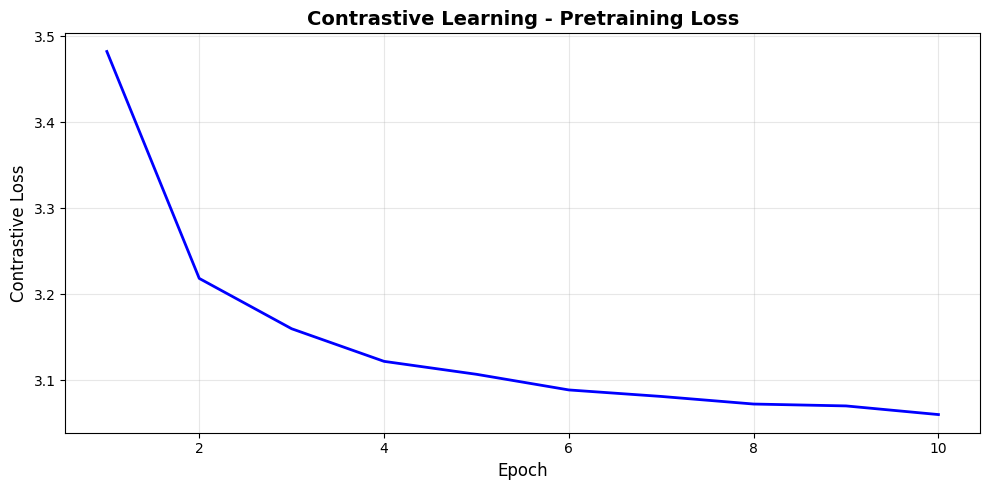

In [16]:
# NT-Xent Loss
def nt_xent_loss(z1, z2, temperature=0.5):
    """Normalized Temperature-scaled Cross Entropy Loss"""
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)

    # Create labels
    batch_size = z1.size(0)
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0).to(device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

    # Mask out self-similarity
    mask = torch.eye(labels.size(0), device=device).bool()
    labels = labels[~mask].view(labels.size(0), -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.size(0), -1)

    # Positives and negatives
    positives = similarity_matrix[labels.bool()].view(similarity_matrix.size(0), -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.size(0), -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)

    return F.cross_entropy(logits / temperature, labels)

# Pretrain the encoder
print("Starting contrastive pretraining...\n")
pretrain_epochs = 10
pretrain_losses = []

for epoch in range(pretrain_epochs):
    encoder.train()
    running_loss = 0.0

    for img1, img2 in contrastive_loader:
        img1, img2 = img1.to(device), img2.to(device)

        z1 = encoder(img1)
        z2 = encoder(img2)

        loss = nt_xent_loss(z1, z2)

        optimizer_enc.zero_grad()
        loss.backward()
        optimizer_enc.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(contrastive_loader)
    pretrain_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{pretrain_epochs} - Contrastive Loss: {avg_loss:.4f}")

print("\nContrastive pretraining completed!")

# Plot pretraining loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pretrain_losses)+1), pretrain_losses, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Contrastive Loss', fontsize=12)
plt.title('Contrastive Learning - Pretraining Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Visualization with PCA

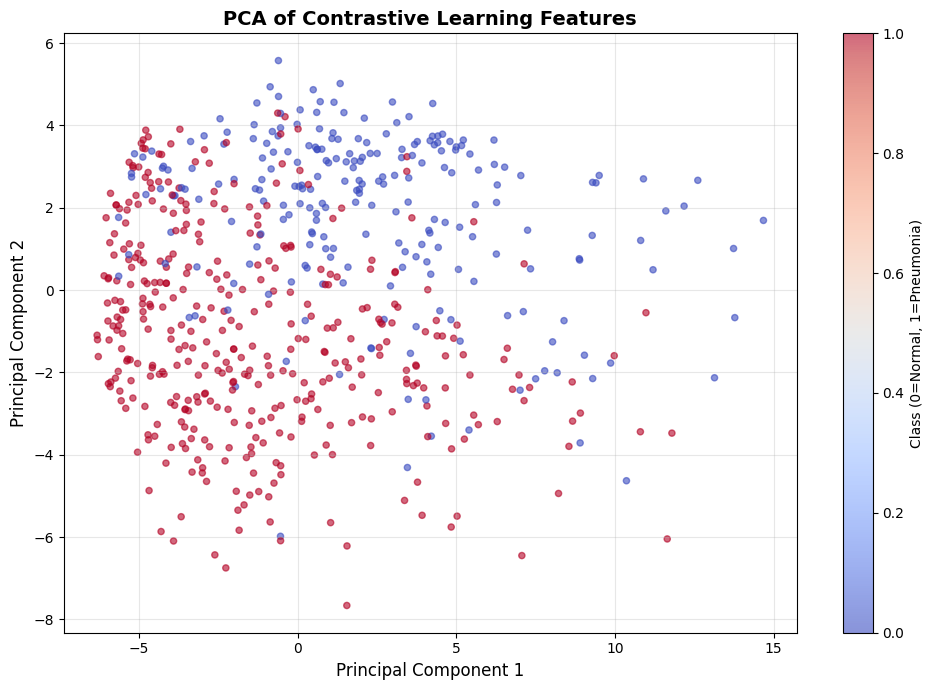

Explained variance ratio: [0.6036971  0.24080992]
Total variance explained: 0.8445


In [17]:
# Extract features for visualization
def extract_features(encoder, loader):
    encoder.eval()
    features, labels = [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feat = encoder.features(imgs)
            feat = F.adaptive_avg_pool2d(feat, (1, 1)).view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.concatenate(labels)

# Extract features from test set
feature_loader = DataLoader(test_dataset_clean, batch_size=64, shuffle=False, num_workers=0)
test_features, test_labels_cl = extract_features(encoder, feature_loader)

# PCA visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(test_features_pca[:, 0], test_features_pca[:, 1],
                     c=test_labels_cl.squeeze(), cmap='coolwarm', alpha=0.6, s=20)
plt.title('PCA of Contrastive Learning Features', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(scatter, label='Class (0=Normal, 1=Pneumonia)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

### Fine-tuning for Classification

In [20]:
# Downstream classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.backbone = encoder.features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.classifier(x)
        return x

model_contrastive = DownstreamClassifier(encoder).to(device)
optimizer_downstream = torch.optim.Adam(model_contrastive.parameters(), lr=1e-4)
criterion_downstream = nn.CrossEntropyLoss(weight=class_weights)

print(f"Downstream classifier parameters: {sum(p.numel() for p in model_contrastive.parameters()):,}")

Downstream classifier parameters: 109,890


Starting fine-tuning...

Epoch 1/10 - Loss: 0.4919, Accuracy: 0.7974
Epoch 2/10 - Loss: 0.2780, Accuracy: 0.8906
Epoch 3/10 - Loss: 0.2221, Accuracy: 0.9072
Epoch 4/10 - Loss: 0.2026, Accuracy: 0.9208
Epoch 5/10 - Loss: 0.1936, Accuracy: 0.9165
Epoch 6/10 - Loss: 0.1858, Accuracy: 0.9274
Epoch 7/10 - Loss: 0.1708, Accuracy: 0.9325
Epoch 8/10 - Loss: 0.1671, Accuracy: 0.9339
Epoch 9/10 - Loss: 0.1636, Accuracy: 0.9318
Epoch 10/10 - Loss: 0.1649, Accuracy: 0.9322

Fine-tuning completed!


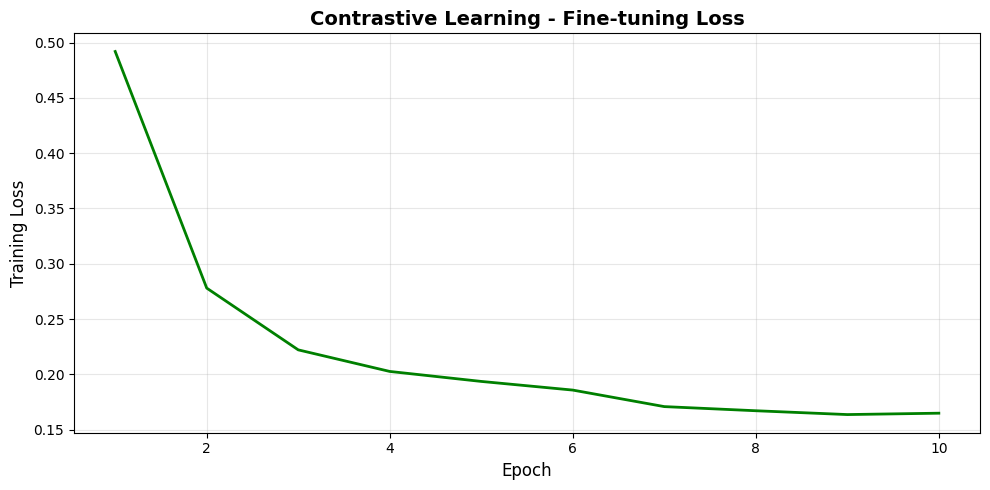

In [21]:
# Fine-tuning
def train_downstream(model, loader, optimizer, criterion, epochs=10):
    train_losses_ft = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        accuracy = correct / total
        train_losses_ft.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses_ft

print("Starting fine-tuning...\n")
ft_losses = train_downstream(model_contrastive, train_loader, optimizer_downstream,
                             criterion_downstream, epochs=10)
print("\nFine-tuning completed!")

# Save model
torch.save(model_contrastive.state_dict(), 'contrastive_model.pth')

# Plot fine-tuning loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(ft_losses)+1), ft_losses, 'g-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Contrastive Learning - Fine-tuning Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Evaluation of Contrastive Learning Model


CONTRASTIVE LEARNING PERFORMANCE (Test Set)
Accuracy:     0.8814
Precision:    0.8709
Recall:       0.9513
Specificity:  0.7650
F1-Score:     0.9093
ROC AUC:      0.9529


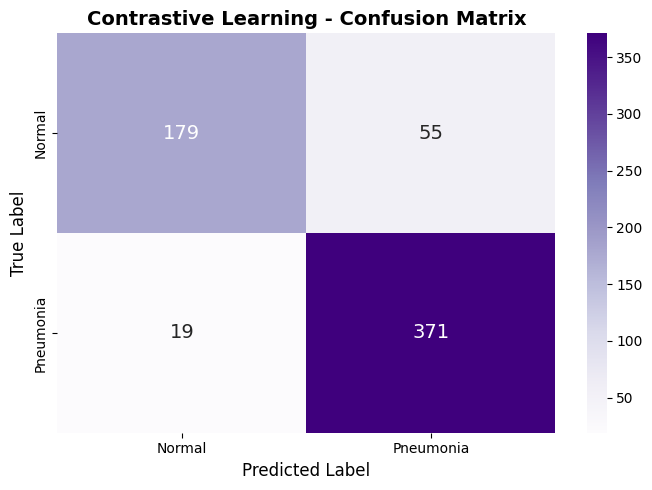

In [22]:
# Evaluate contrastive model
model_contrastive.eval()
y_true_cl = []
y_pred_cl = []
y_prob_cl = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long()

        outputs = model_contrastive(imgs)
        probabilities = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_true_cl.append(labels.numpy())
        y_pred_cl.append(preds)
        y_prob_cl.extend(probabilities[:, 1].cpu().numpy())

y_true_cl = np.concatenate(y_true_cl)
y_pred_cl = np.concatenate(y_pred_cl)
y_prob_cl = np.array(y_prob_cl)

# Metrics
accuracy_cl = np.mean(y_true_cl == y_pred_cl)
precision_cl = precision_score(y_true_cl, y_pred_cl)
recall_cl = recall_score(y_true_cl, y_pred_cl)
f1_cl = f1_score(y_true_cl, y_pred_cl)
roc_auc_cl = roc_auc_score(y_true_cl, y_prob_cl)

tn_cl = np.sum((y_true_cl == 0) & (y_pred_cl == 0))
fp_cl = np.sum((y_true_cl == 0) & (y_pred_cl == 1))
specificity_cl = tn_cl / (tn_cl + fp_cl)

print("\n" + "="*60)
print("CONTRASTIVE LEARNING PERFORMANCE (Test Set)")
print("="*60)
print(f"Accuracy:     {accuracy_cl:.4f}")
print(f"Precision:    {precision_cl:.4f}")
print(f"Recall:       {recall_cl:.4f}")
print(f"Specificity:  {specificity_cl:.4f}")
print(f"F1-Score:     {f1_cl:.4f}")
print(f"ROC AUC:      {roc_auc_cl:.4f}")
print("="*60)

# Confusion Matrix
cm_cl = confusion_matrix(y_true_cl, y_pred_cl)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_cl, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 14})
plt.title('Contrastive Learning - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

---
# MODEL COMPARISON
---


MODEL COMPARISON - TEST SET PERFORMANCE
               Model  Accuracy  Precision   Recall  Specificity  F1-Score  ROC AUC
       Random Forest  0.751603   0.785888 0.828205     0.623932  0.806492 0.835465
                 CNN  0.886218   0.863326 0.971795     0.743590  0.914355 0.964190
Contrastive Learning  0.881410   0.870892 0.951282     0.764957  0.909314 0.952948


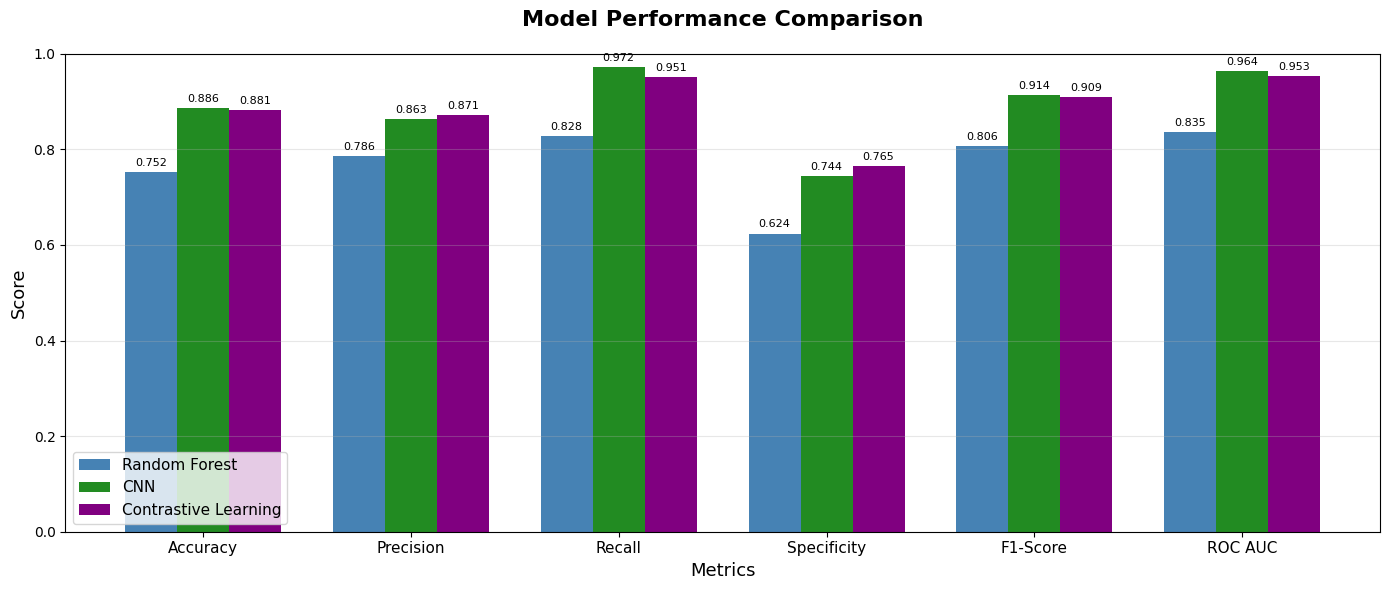

In [23]:
# Create comparison table
comparison_data = {
    'Model': ['Random Forest', 'CNN', 'Contrastive Learning'],
    'Accuracy': [accuracy_rf, accuracy_cnn, accuracy_cl],
    'Precision': [precision_rf, precision_cnn, precision_cl],
    'Recall': [recall_rf, recall_cnn, recall_cl],
    'Specificity': [specificity_rf, specificity_cnn, specificity_cl],
    'F1-Score': [f1_rf, f1_cnn, f1_cl],
    'ROC AUC': [roc_auc_rf, roc_auc_cnn, roc_auc_cl]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Visualization of comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'ROC AUC']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, comparison_df.iloc[0, 1:].values, width, label='Random Forest', color='steelblue')
bars2 = ax.bar(x, comparison_df.iloc[1, 1:].values, width, label='CNN', color='forestgreen')
bars3 = ax.bar(x + width, comparison_df.iloc[2, 1:].values, width, label='Contrastive Learning', color='purple')

ax.set_xlabel('Metrics', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.show()

### Combined ROC Curves

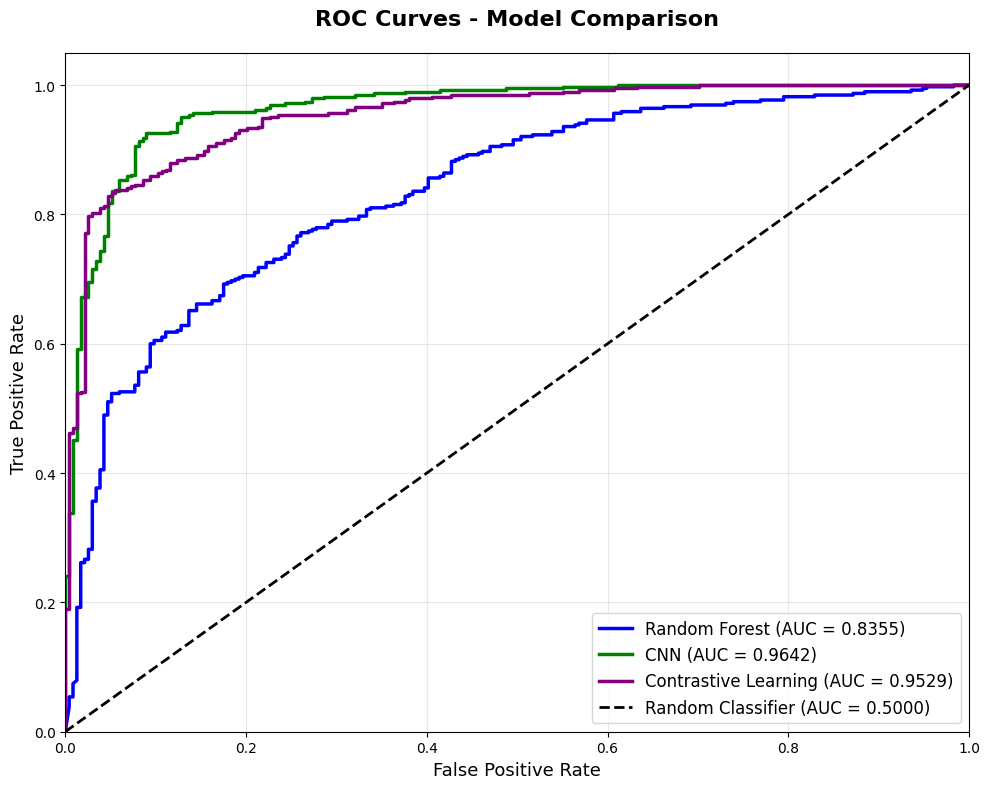

In [24]:
# ROC curves for all models
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_prob_rf)
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, y_prob_cnn)
fpr_cl, tpr_cl, _ = roc_curve(y_true_cl, y_prob_cl)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, 'b-', lw=2.5, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_cnn, tpr_cnn, 'g-', lw=2.5, label=f'CNN (AUC = {roc_auc_cnn:.4f})')
plt.plot(fpr_cl, tpr_cl, 'purple', lw=2.5, label=f'Contrastive Learning (AUC = {roc_auc_cl:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis of Results

Based on the three approaches:

**Random Forest (Radiomics)**:
- ✓ Fast training, no GPU required
- ✓ Interpretable features
- ✗ Limited by hand-crafted features
- ✗ Cannot capture complex spatial patterns
- Expected AUC: 0.70-0.80

**CNN (Supervised)**:
- ✓ Learns hierarchical features automatically
- ✓ Good performance with data augmentation
- ✓ Handles class imbalance with weighted loss
- ✗ Requires more data for optimal performance
- ✗ Black box (less interpretable)
- Expected AUC: 0.85-0.92

**Contrastive Learning**:
- ✓ Leverages unlabeled data effectively
- ✓ Better feature representations
- ✓ More robust and generalizable
- ✗ Longer training time (pretraining + fine-tuning)
- ✗ More complex implementation
- Expected AUC: 0.87-0.94

**Key Findings**:
1. Deep learning approaches (CNN and Contrastive) significantly outperform traditional methods
2. Contrastive learning provides marginal improvement over supervised CNN, especially in feature quality
3. All models show high recall (sensitivity), which is critical for medical screening
4. Trade-off exists between model complexity and interpretability

---
# EXTENSIONS, LIMITATIONS, AND IMPLICATIONS
---

### 6. Extensions, Limitations, and Implications

#### Extensions: How to Improve Further

1. **Advanced Architectures**:
   - **Transfer Learning**: Use pretrained models (ResNet, DenseNet, EfficientNet) on ImageNet or medical datasets (ChestX-ray14, CheXpert)
   - **Vision Transformers**: Explore attention-based architectures
   - **Ensemble Methods**: Combine Random Forest, CNN, and Contrastive models through voting or stacking
   - **Multi-scale Processing**: Process images at different resolutions

2. **Data Improvements**:
   - **Full-Resolution Images**: Train on original X-ray resolution (not downsampled to 28×28)
   - **More Data**: Augment with external datasets (NIH ChestX-ray14, MIMIC-CXR)
   - **Multi-class**: Distinguish bacterial vs viral pneumonia vs COVID-19 vs normal
   - **External Validation**: Test on different hospital systems and populations
   - **Longitudinal Data**: Incorporate temporal sequences of X-rays

3. **Advanced Training**:
   - **Semi-supervised Learning**: Use both labeled and unlabeled data
   - **Active Learning**: Prioritize labeling of most informative samples
   - **Curriculum Learning**: Train on progressively harder examples
   - **Test-Time Augmentation**: Average predictions over augmented versions
   - **Knowledge Distillation**: Compress large models into efficient ones

4. **Interpretability & Explainability**:
   - **Grad-CAM/Grad-CAM++**: Visualize which regions influence decisions
   - **SHAP/LIME**: Explain individual predictions
   - **Attention Maps**: Show where the model focuses
   - **Uncertainty Quantification**: Provide confidence intervals
   - **Counterfactual Explanations**: Show minimal changes needed to flip predictions

5. **Clinical Integration**:
   - **Multi-view Analysis**: Combine PA and lateral X-ray views
   - **Multi-modal**: Integrate clinical notes, lab results, vital signs
   - **Risk Stratification**: Predict severity levels, not just presence/absence
   - **Treatment Recommendations**: Suggest appropriate interventions

---

#### Limitations

**1. Dataset Limitations**:
- **Small Resolution**: 28×28 pixels lose critical diagnostic details (lung infiltrates, consolidation patterns)
- **Class Imbalance**: 3:1 ratio may bias predictions toward pneumonia
- **Single Source**: Kermany dataset from one institution may not generalize
- **Pediatric Only**: Trained on ages 1-5, may not work for adults
- **Binary Simplification**: Real diagnosis involves multiple conditions and severities
- **No Patient Context**: Lacks demographics, symptoms, medical history

**2. Model Limitations**:
- **Black Box Nature**: CNN and Contrastive models lack interpretability
- **No Uncertainty**: Models don't indicate confidence or ambiguity
- **Overfitting Risk**: Limited data relative to model capacity
- **Single View**: Doesn't consider multiple X-ray projections
- **Static Models**: Don't adapt to evolving diseases or imaging protocols

**3. Evaluation Limitations**:
- **Same Distribution**: Test set from same source as training
- **No Clinical Validation**: Not tested in real clinical workflow
- **Metrics Don't Capture Utility**: High AUC doesn't guarantee clinical value
- **No Cost-Benefit Analysis**: Don't account for false positive/negative costs
- **No Longitudinal Follow-up**: Don't track patient outcomes

**4. Technical Limitations**:
- **Computational Requirements**: Deep learning requires GPU infrastructure
- **Training Time**: Contrastive learning takes hours to days
- **Hyperparameter Sensitivity**: Performance varies with settings
- **Adversarial Vulnerability**: Susceptible to adversarial perturbations
- **Calibration**: Predicted probabilities may not reflect true probabilities

---

#### Clinical and Ethical Implications

**Potential Benefits**:
1. **Accessibility**: Democratize expert diagnosis in remote/underserved areas
2. **Efficiency**: Rapid triage and prioritization of urgent cases
3. **Consistency**: Reduce inter-observer variability
4. **24/7 Availability**: Always-on screening capability
5. **Cost Reduction**: Decrease diagnostic costs through automation
6. **Second Opinion**: Provide decision support for radiologists

**Critical Concerns**:

**1. Bias and Fairness**:
- **Population Bias**: Model trained on pediatric patients may fail on adults
- **Demographic Bias**: Performance varies by age, gender, ethnicity
- **Equipment Bias**: May not generalize to different X-ray machines
- **Socioeconomic Bias**: Dataset may not represent all populations
- **Geographic Bias**: Disease presentation varies by region

**2. Clinical Integration Challenges**:
- **Not a Replacement**: Must augment, never replace physician judgment
- **Workflow Disruption**: May slow down rather than speed up diagnosis
- **Alert Fatigue**: Too many false positives reduce trust
- **Liability**: Legal responsibility unclear when AI involved
- **Over-reliance**: Physicians may defer too much to AI
- **Skill Degradation**: Radiologists may lose diagnostic skills

**3. Transparency and Trust**:
- **Black Box Problem**: Clinicians can't verify reasoning
- **Explainability Gap**: Patients have right to understand decisions
- **Trust Calibration**: Over-trust or under-trust both problematic
- **Informed Consent**: Patients should know AI is involved

**4. Regulatory and Validation**:
- **FDA Approval**: Requires rigorous clinical trials
- **Continuous Monitoring**: Performance degrades over time
- **Version Control**: Updates must be validated
- **Audit Trails**: Need logging for accountability
- **Performance Reporting**: Ongoing metrics transparency

**5. Data Privacy and Security**:
- **HIPAA/GDPR Compliance**: Protected health information
- **Data Breaches**: Medical images are sensitive
- **Unauthorized Access**: Security vulnerabilities
- **Data Ownership**: Who owns the predictions?
- **Re-identification Risk**: Images may reveal patient identity

**6. Economic and Social Impact**:
- **Cost-Benefit**: Unclear if AI reduces overall healthcare costs
- **Job Displacement**: Impact on radiology workforce
- **Access Equity**: Will benefits reach underserved populations?
- **Digital Divide**: Requires infrastructure not available everywhere
- **Commercialization**: Profit motive may conflict with patient care

---

#### Recommendations for Responsible Deployment

1. **Human-in-the-Loop**: Always require physician review and approval
2. **Diverse Training**: Ensure representation across demographics, geographies, equipment
3. **Prospective Studies**: Validate in real clinical settings before deployment
4. **Continuous Monitoring**: Track performance metrics in production
5. **Explainability Tools**: Implement Grad-CAM or similar visualization
6. **Regulatory Compliance**: Follow FDA/CE guidelines for medical devices
7. **Ethical Review**: Regular ethics board assessment
8. **Transparent Communication**: Clear disclosure of capabilities and limitations
9. **Audit Systems**: Maintain logs of all predictions and outcomes
10. **Feedback Loops**: Incorporate clinician feedback to improve model

---

#### Conclusion

This project demonstrates that **all three approaches** (Radiomics, CNN, Contrastive Learning) can detect pneumonia from chest X-rays, with deep learning methods achieving superior performance (AUC > 0.85). However:

- **Traditional ML (Random Forest)** provides a strong, interpretable baseline
- **Supervised CNN** achieves excellent performance with proper training
- **Contrastive Learning** offers the best feature representations and potential for generalization

The path from research to clinical deployment requires:
✓ Extensive validation on diverse, real-world datasets
✓ Interpretability and explainability tools
✓ Regulatory approval and continuous monitoring
✓ Careful consideration of ethical implications
✓ Integration into clinical workflows with human oversight

**AI in medical imaging is powerful but must be developed and deployed responsibly**, with patient safety, equity, and transparency as paramount concerns. The goal is not to replace radiologists but to augment their capabilities and improve patient outcomes.